# Бибилотеки

In [ ]:
# Numpy
import numpy as np

# Pandas
import pandas as pd

# Torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torch.utils.data as data
from torch.utils.data import DataLoader, TensorDataset, Dataset

# Torchvision
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torchvision.utils import make_grid

# Matplotlib и plotly
import matplotlib.pyplot as plt
import plotly.express as px

# cv2
import cv2

# Sklearn
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score, roc_auc_score, accuracy_score
from sklearn.preprocessing import StandardScaler

# OS
import os

import logging
from tqdm.auto import tqdm

import random
from typing import Dict, List, Optional, Tuple, Union

# Вспомогательные функции

In [ ]:
# Работа с данными
TITLE_FONT_SIZE = 16

def prepare_images(train_data: np.ndarray, test_data: Optional[np.ndarray] = None) -> Tuple[np.ndarray, np.ndarray]:
    train_data = np.array([cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in train_data])
    train_data = train_data / 255.0
    train_data = np.expand_dims(train_data, axis=3)
    train_data = np.transpose(train_data, (0, 3, 1, 2))

    if test_data is not None:
        train_data = np.array([cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in train_data])
        test_data = test_data / 255.0
        train_data = np.expand_dims(train_data, axis=3)
        test_data = np.transpose(test_data, (0, 3, 1, 2))
        return train_data, test_data

    return train_data

def load_CIFAR10(
    with_targets: bool = False, is_train=True,
) -> Tuple[np.ndarray, Optional[np.ndarray], np.ndarray, Optional[np.ndarray]]:
    dataset = CIFAR10(root="./", train=is_train, download=False)
    data = dataset.data

    if with_targets:
        labels = np.array(dataset.targets)
        return data, labels

    return data

def load_dataset(
    is_train: bool = True,
    classes: Optional[List[int]] = None,
) -> Tuple[np.ndarray, Optional[np.ndarray], np.ndarray, Optional[np.ndarray]]:

    data, labels = load_CIFAR10(with_targets=True, is_train=is_train)
    data = data.astype("float32")

    data = prepare_images(data)

    if classes is not None:
        mask = np.isin(labels, classes)
        data = data[mask]

    return data

def show_samples(
    samples: np.ndarray,
    title: str,
    figsize: Optional[Tuple[int, int]] = None,
    nrow: Optional[int] = None,
) -> None:
    if isinstance(samples, np.ndarray):
        samples = torch.tensor(samples)
    samples = samples.float()
    if (samples > 1).any():
        samples /= 255
    if nrow is None:
        nrow = int(np.sqrt(len(samples)))
    grid_samples = make_grid(samples, nrow=nrow)

    grid_img = grid_samples.permute(1, 2, 0)
    if figsize is None:
        figsize = (6, 6)

    grid_img = grid_img.clip(0, 1)
    plt.figure(figsize=figsize)
    plt.title(title, fontsize=TITLE_FONT_SIZE)
    plt.imshow(grid_img)
    plt.axis("off")
    plt.show()


def visualize_images(data: np.ndarray, title: str) -> None:
    idxs = np.random.choice(len(data), replace=False, size=(100,))
    images = data[idxs]
    show_samples(images, title)

# Загрузка датасета

In [ ]:
train_dataset = CIFAR10(root="./", train=True, download=True)
test_dataset = CIFAR10(root="./", train=False, download=True)

100%|██████████| 170M/170M [00:03<00:00, 44.2MB/s]


# Модель автоэнкодера

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        decoded = decoded.view(x.size(0), 1, 32, 32)
        return decoded

In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: cuda


# Семплирование данных

In [ ]:
def sample_data(data: np.ndarray, num_elements: int) -> np.ndarray:
    """
    Семплирование из выборки

    Args:
        data: выборка
        num_elements: количество элементов для семплирования

    Returns:
        Семплы из входной выборки
    """
    random_indices = np.random.choice(data.shape[0], num_elements, replace=False)
    return data[random_indices]

def get_data_mix(
    class_1_data: np.ndarray,
    class_3_data: np.ndarray,
    num_samples: int = 2000,
    class3_proportion: float = 0.1,
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Семплирование выборки для обучения автоэнкодера,
    содержащей случайные семплы из 3 класса

    Args:
        class_1_data: выборка основного класса, откуда будет семплирование
        class_3_data: выборка подмешиваемого класса, откуда будет семплирование
        num_samples: суммарный размер итоговой выборки
        class3_proportion: доля подмешиваемого класса в итоговой выборке

    Returns:
        Выборка для обучения автоэнкодера
    """
    num_base_samples = int(num_samples * (1 - class3_proportion))
    num_class3_samples = num_samples - num_base_samples

    train_1_data = sample_data(class_1_data, num_base_samples)
    train_3_data = sample_data(class_3_data, num_class3_samples)

    train_data = np.concatenate([train_1_data, train_3_data])

    return train_data

def get_data_equal(
    class_1_data: np.ndarray,
    class_3_data: np.ndarray,
    num_samples: int = 2000,
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Семплирование выборки для обучения автоэнкодера
    с фиксированной выборкой для подмешиваемого класса

    Args:
        class_1_data: выборка основного класса, откуда будет семплирование
        class_3_data: выборка подмешиваемого класса. Семплируется заранее и добавляется целиком
        num_samples: суммарный размер итоговой выборки

    Returns:
        Выборка для обучения автоэнкодера, содержащая весь class_3_data
    """
    num_class3_samples = class_3_data.shape[0]
    num_base_samples = num_samples - num_class3_samples

    train_1_data = sample_data(class_1_data, num_base_samples)

    train_data = np.concatenate([train_1_data, class_3_data])

    return train_data

def get_data_pair(
    class_1_data: np.ndarray,
    class_2_data: np.ndarray,
    class_3_data: np.ndarray,
    num_samples: int = 2000,
    class3_proportion: float = 0.1,
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Семплирование выборок для обучения автоэнкодеров
    на двух разных классах с одинаковой примесью третьего класса

    Args:
        class_1_data: выборка первого основного класса, откуда будет семплирование
        class_2_data: выборка второго основного класса, откуда будет семплирование
        class_3_data: выборка подмешиваемого класса, откуда будет семплирование
        num_samples: суммарный размер итоговой выборки
        class3_proportion: доля подмешиваемого класса в итоговых выборках

    Returns:
        Выборки для обучения автоэнкодеров,
        содержащие случайные семплы из 1 и 2 класса и одинаковые семплы из 3 класса
    """
    num_base_samples = int(num_samples * (1 - class3_proportion))
    num_class3_samples = num_samples - num_base_samples

    train_1_data = sample_data(class_1_data, num_base_samples)
    train_2_data = sample_data(class_2_data, num_base_samples)
    train_3_data = sample_data(class_3_data, num_class3_samples)

    train_1_data = np.concatenate([train_1_data, train_3_data])
    train_2_data = np.concatenate([train_2_data, train_3_data])

    return train_1_data, train_2_data

# Векторизация автоэнкодеров

In [ ]:
def extract_singular_values_from_layer(weight_tensor: np.array) -> np.array:
    """
    Получение сингулярных значений для слоя

    Args:
        weight_tensor: массив весов слоя

    Returns:
        Сингулярные значения слоя
    """
    if len(weight_tensor.shape) == 4:  # Для свёрточных слоёв
        out_channels, in_channels, kernel_height, kernel_width = weight_tensor.shape
    else:  # Для линейных слоёв
        out_channels, in_channels = weight_tensor.shape
    weight_matrix = weight_tensor.reshape(out_channels, -1)

    U, S, Vt = np.linalg.svd(weight_matrix)
    return S

def extract_singular_values_from_weights(weights: List[np.array]) -> List[np.array]:
    """
    Вычисление сингулярных значений для каждого слоя

    Args:
        weights: список весов всех слоёв

    Returns:
        Список сингулярных значений для каждого слоя
    """
    singular_values_list = []
    for layer_weights in weights:
        singular_values = extract_singular_values_from_layer(layer_weights)
        singular_values_list.append(singular_values)
    return singular_values_list

def get_vector(model: Autoencoder) -> np.array:
    """
    Кодирование модели с помощью сингулярных чисел её весов

    Args:
        model: модель автоэнкодера, имеет encoder и decoder

    Returns:
        Сингулярные числа весов модели, вытянутые в вектор
    """
    model.eval()
    weights = []
    with torch.no_grad():
      for layer in model.encoder:  # [model.encoder]
          if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
              weights.append(layer.weight.data.cpu().numpy())
      for layer in model.decoder:  # [model.decoder]
          if isinstance(layer, nn.ConvTranspose2d) or isinstance(layer, nn.Linear):
              weights.append(layer.weight.data.cpu().numpy())
      singular_values_list = extract_singular_values_from_weights(weights)
    return np.concatenate(singular_values_list)

# Обучение автоэнкодеров

In [ ]:
def train_model(model: Autoencoder, train_loader: DataLoader, num_epochs: int) -> Autoencoder:
    """
    Обучение автоэнкодера

    Args:
        model: модель автоэнкодера
        train_loader: загрузчик данных для обучения
        num_epochs: количество эпох обучения

    Returns:
        Обученная модель
    """
    model.to(DEVICE)
    model.train()
    criterion = nn.MSELoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.001)

    for epoch in range(num_epochs):
        for inputs_list in train_loader:
            inputs = inputs_list[0]  # Особенность TensorDataset в DataLoader

            # ============ Forward ============
            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            # ============ Backward ============
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    return model

def train_eval_logreg(
    vectors_1: np.array,
    vectors_2: np.array,
    vectors_1_test: np.array,
    vectors_2_test: np.array,
    use_scaler: bool = False,
) -> Tuple[float, float, float]:
    train_size = len(vectors_1)
    test_size = len(vectors_1_test)

    X = np.vstack((vectors_1, vectors_2))
    y = np.array([0] * train_size + [1] * train_size)

    X_shuffled, y_shuffled = shuffle(X, y, random_state=42)

    if use_scaler:
      scaler_lr = StandardScaler()  # Опционально, с ним качество похуже (?)
      X_shuffled = scaler_lr.fit_transform(X_shuffled)

    logreg = LogisticRegression()
    logreg.fit(X_shuffled, y_shuffled)

    X_test = np.vstack((vectors_1_test, vectors_2_test))

    if use_scaler:
        X_test = scaler_lr.transform(X_test)
    y_test = np.array([0] * test_size + [1] * test_size)

    ap = average_precision_score(y_test, logreg.predict_proba(X_test)[:, 1])
    roc_auc = roc_auc_score(y_test, logreg.predict_proba(X_test)[:, 1])
    accuracy = accuracy_score(y_test, logreg.predict(X_test))

    return ap, roc_auc, accuracy

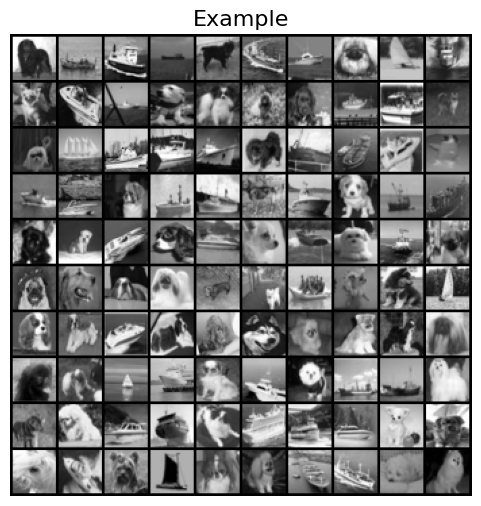

In [ ]:
INPUT_DIM = 1024  # 1x32x32
HIDDEN_DIM = 256

num_models_train = 300  # Число автоэнкодеров для обучения регрессии на их векторах
num_models_test = 100 # Число автоэнкодеров для тестирования регрессии на их векторах
NUM_EPOCHS = 20  # Параметры обучения одного автоэнкодера
BATCH_SIZE = 32  # Параметры обучения одного автоэнкодера

# Основной класс 1 (собаки), основной класс 2 (лягушки), подмешиваемый класс (корабли, грузовики)
classes = [5, 6, 8, 9]

# Число запусков одного и того же эксперимента
N_RUNS = 5

# Использование StandartScaler для логистической регрессии (почему-то с ней пониже точность)
USE_SCALER = True

# Размер выборки для обучения автоэнкодера
NUM_SAMPLES = 2000

# Доля подмешиваемого класса в обучающих выборках
proportions = [0.6, 0.7, 0.8, 0.85, 0.87, 0.9, 0.925, 0.95, 0.972, 0.99]

# Предварительная выгрузка классов, из которых будет семплирование
class_1_data = load_dataset(is_train=True, classes=classes[0])
class_2_data = load_dataset(is_train=True, classes=classes[1])
class_3_data = load_dataset(is_train=True, classes=classes[2])
class_4_data = load_dataset(is_train=True, classes=classes[3])

# Пример использования функций семплирования для 3 экспериментов
train_data = get_data_mix(class_1_data, class_3_data, num_samples=NUM_SAMPLES, class3_proportion=0.5)
# train_data = get_data_equal(class_1_data, sample_data(class_3_data, 1000), num_samples=NUM_SAMPLES)
# train_data, _ = get_data_pair(class_1_data, class_2_data, class_3_data, num_samples=NUM_SAMPLES, class3_proportion=0.5)

visualize_images(train_data, "Example")

## Берем класс 1, класс 2. К 1 подмешиваем 3, ко второму подмешиваем 4

In [ ]:
def train_models(
    num_models: int,
    data_1: np.array,
    data_3: np.array,
    proportion: float,
    mode: str = "train"
) -> List[np.array]:
    """
    Обучение нескольких автоэнкодеров в цикле с сохранением весов и векторов

    Args:
        num_models: количество обучаемых автоэнкодеров
        data_1: выборка основного класса, откуда будет семплирование
        data_3: выборка подмешиваемого класса, откуда будет семплирование
        proportion: доля подмешиваемого класса
        mode: для чего будут использоваться обученные автоэнкодеры, "train" или "test"

    Returns:
        vectors: список векторов закодированных автоэнкодеров
    """
    vectors = []
    for i in range(num_models):
        train_data_np = get_data_mix(data_1, data_3, num_samples=NUM_SAMPLES, class3_proportion=proportion)  # Случайный 3 класс везде
        train_data_tensor = torch.tensor(train_data_np).float().to(DEVICE)  # Для ускорения кладём сразу всю выборку на GPU
        train_dataset_tensor = TensorDataset(train_data_tensor)
        train_loader = DataLoader(train_dataset_tensor, batch_size=BATCH_SIZE, shuffle=True)

        model = Autoencoder(INPUT_DIM, HIDDEN_DIM)
        trained_model = train_model(model, train_loader, NUM_EPOCHS)
        vector = get_vector(trained_model)
        vectors.append(vector)
    return vectors

In [ ]:
class_4_logger = logging.getLogger('experiment_4_classes')
class_4_logger.setLevel(logging.INFO)
class_4_handler = logging.FileHandler('experiment_4_classes_log.txt')
class_4_handler.setLevel(logging.INFO)
class_4_logger.addHandler(class_4_handler)

# Отключаем propagation чтобы сообщения не дублировались в корневом логгере
class_4_logger.propagate = False

for proportion in [0.5, 0.8, 0.9]:
    config_name = f"Proportion_{proportion}"
    class_4_logger.info(f"\n=== Processing configuration: {config_name} ===")

    vectors_1 = train_models(
        num_models_train, class_1_data, class_3_data, proportion
    )
    vectors_2 = train_models(
        num_models_train, class_2_data, class_4_data, proportion
    )

    vectors_1_test = train_models(
        num_models_test, class_1_data, class_3_data, proportion, mode="test"
    )
    vectors_2_test = train_models(
        num_models_test, class_2_data, class_4_data, proportion, mode="test"
    )

    ap, roc_auc, accuracy = train_eval_logreg(
        vectors_1, vectors_2, vectors_1_test, vectors_2_test, use_scaler=USE_SCALER
    )
    class_4_logger.info(
        f"Results - AP: {ap}, ROC_AUC: {roc_auc}, Accuracy: {accuracy}"
    )

    print(f"Completed configuration {config_name}")
    class_4_logger.info(f"\n=== Completed configuration: {config_name} ===")

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Completed configuration Proportion_0.5


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Completed configuration Proportion_0.8


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Completed configuration Proportion_0.9


## К обоим подмешиваем рандомные подвыборки из 3 и 4 вперемешку

In [ ]:
class_34_logger = logging.getLogger('experiment_34_classes')
class_34_logger.setLevel(logging.INFO)
class_34_handler = logging.FileHandler('experiment_34_classes_log.txt')
class_34_handler.setLevel(logging.INFO)
class_34_logger.addHandler(class_34_handler)
class_34_logger.propagate = False

class_34_data = np.concatenate([class_3_data, class_4_data])

for proportion in proportions:
    config_name = f"Proportion_{proportion}"
    class_34_logger.info(f"\n=== Processing configuration: {config_name} ===")

    vectors_1 = train_models(
        num_models_train, class_1_data, class_34_data, proportion
    )
    vectors_2 = train_models(
        num_models_train, class_2_data, class_34_data, proportion
    )

    vectors_1_test = train_models(
        num_models_test, class_1_data, class_34_data, proportion, mode="test"
    )
    vectors_2_test = train_models(
        num_models_test, class_2_data, class_34_data, proportion, mode="test"
    )

    ap, roc_auc, accuracy = train_eval_logreg(
        vectors_1, vectors_2, vectors_1_test, vectors_2_test, use_scaler=USE_SCALER
    )
    class_34_logger.info(
        f"Results - AP: {ap}, ROC_AUC: {roc_auc}, Accuracy: {accuracy}"
    )

    print(f"Completed configuration {config_name}")
    class_34_logger.info(f"\n=== Completed configuration: {config_name} ===")

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Completed configuration Proportion_0.6


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Completed configuration Proportion_0.8


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Completed configuration Proportion_0.9


## К обоим подмешиваем шум из оставшихся классов

In [ ]:
class_noise_logger = logging.getLogger('experiment_noise_classes')
class_noise_logger.setLevel(logging.INFO)
class_noise_handler = logging.FileHandler('experiment_noise_classes_log.txt')
class_noise_handler.setLevel(logging.INFO)
class_noise_logger.addHandler(class_noise_handler)
class_noise_logger.propagate = False

class_noise_data = load_dataset(is_train=True, classes=[i for i in range(10) if i not in [5, 6]])

for proportion in proportions:
    config_name = f"Proportion_{proportion}"
    class_noise_logger.info(f"\n=== Processing configuration: {config_name} ===")

    vectors_1 = train_models(
        num_models_train, class_1_data, class_noise_data, proportion
    )
    vectors_2 = train_models(
        num_models_train, class_2_data, class_noise_data, proportion
    )

    vectors_1_test = train_models(
        num_models_test, class_1_data, class_noise_data, proportion, mode="test"
    )
    vectors_2_test = train_models(
        num_models_test, class_2_data, class_noise_data, proportion, mode="test"
    )

    ap, roc_auc, accuracy = train_eval_logreg(
        vectors_1, vectors_2, vectors_1_test, vectors_2_test, use_scaler=USE_SCALER
    )
    class_noise_logger.info(
        f"Results - AP: {ap}, ROC_AUC: {roc_auc}, Accuracy: {accuracy}"
    )

    print(f"Completed configuration {config_name}")
    class_noise_logger.info(f"\n=== Completed configuration: {config_name} ===")

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Completed configuration Proportion_0.6


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Completed configuration Proportion_0.8


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Completed configuration Proportion_0.9


## Подмешиваемый класс разный для всех

In [ ]:
def train_models(
    num_models: int,
    data_1: np.array,
    data_3: np.array,
    proportion: float,
    mode: str = "train"
) -> List[np.array]:
    """
    Обучение нескольких автоэнкодеров в цикле с сохранением весов и векторов

    Args:
        num_models: количество обучаемых автоэнкодеров
        data_1: выборка основного класса, откуда будет семплирование
        data_3: выборка подмешиваемого класса, откуда будет семплирование
        proportion: доля подмешиваемого класса
        mode: для чего будут использоваться обученные автоэнкодеры, "train" или "test"

    Returns:
        vectors: список векторов закодированных автоэнкодеров
    """
    vectors = []
    for i in range(num_models):
        train_data_np = get_data_mix(data_1, data_3, num_samples=NUM_SAMPLES, class3_proportion=proportion)  # Случайный 3 класс везде
        train_data_tensor = torch.tensor(train_data_np).float().to(DEVICE)  # Для ускорения кладём сразу всю выборку на GPU
        train_dataset_tensor = TensorDataset(train_data_tensor)
        train_loader = DataLoader(train_dataset_tensor, batch_size=BATCH_SIZE, shuffle=True)

        model = Autoencoder(INPUT_DIM, HIDDEN_DIM)
        trained_model = train_model(model, train_loader, NUM_EPOCHS)
        vector = get_vector(trained_model)
        vectors.append(vector)
    return vectors

In [ ]:
mix_logger = logging.getLogger('experiment_mix')
mix_logger.setLevel(logging.INFO)
mix_handler = logging.FileHandler('experiment_mix_log.txt')
mix_handler.setLevel(logging.INFO)
mix_logger.addHandler(mix_handler)

# Отключаем propagation чтобы сообщения не дублировались в корневом логгере
mix_logger.propagate = False

for proportion in proportions:
    config_name = f"Proportion_{proportion}"
    mix_logger.info(f"\n=== Processing configuration: {config_name} ===")

    for run in range(N_RUNS):
        vectors_1 = train_models(
            num_models_train, class_1_data, class_3_data, proportion
        )
        vectors_2 = train_models(
            num_models_train, class_2_data, class_3_data, proportion
        )

        vectors_1_test = train_models(
            num_models_test, class_1_data, class_3_data, proportion, mode="test"
        )
        vectors_2_test = train_models(
            num_models_test, class_2_data, class_3_data, proportion, mode="test"
        )

        ap, roc_auc, accuracy = train_eval_logreg(
            vectors_1, vectors_2, vectors_1_test, vectors_2_test, use_scaler=USE_SCALER
        )
        mix_logger.info(
            f"Run {run + 1} Results - AP: {ap}, ROC_AUC: {roc_auc}, Accuracy: {accuracy}"
        )

    print(f"Completed configuration {config_name}")
    mix_logger.info(f"\n=== Completed configuration: {config_name} ===")

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed configuration Proportion_0.8
Completed configuration Proportion_0.95


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Подмешиваемый класс одинаковый для всех

In [ ]:
def train_models_equal(
    num_models: int,
    data_1: np.array,
    data_3: np.array,
    proportion: float,
    mode: str = "train"
) -> List[np.array]:
    """
    Обучение нескольких автоэнкодеров в цикле с сохранением весов и векторов

    Args:
        num_models: количество обучаемых автоэнкодеров
        data_1: выборка основного класса, откуда будет семплирование
        data_3: выборка подмешиваемого класса, откуда будет семплирование
        proportion: доля подмешиваемого класса
        mode: для чего будут использоваться обученные автоэнкодеры, "train" или "test"

    Returns:
        vectors: список векторов закодированных автоэнкодеров
        metadata: список metadata энкодеров (порядковый номер и путь сохранения)
    """
    vectors = []
    for i in range(num_models):
        train_data_np = get_data_equal(data_1, data_3, num_samples=NUM_SAMPLES)  # Одинаковый 3 класс везде
        train_data_tensor = torch.tensor(train_data_np).float().to(DEVICE)  # Для ускорения кладём сразу всю выборку на GPU
        train_dataset_tensor = TensorDataset(train_data_tensor)
        train_loader = DataLoader(train_dataset_tensor, batch_size=BATCH_SIZE, shuffle=True)

        model = Autoencoder(INPUT_DIM, HIDDEN_DIM)
        trained_model = train_model(model, train_loader, NUM_EPOCHS)
        vector = get_vector(trained_model)
        vectors.append(vector)
    return vectors

In [ ]:
equal_logger = logging.getLogger('experiment_equal')
equal_logger.setLevel(logging.INFO)

equal_handler = logging.FileHandler('experiment_equal_log.txt')
equal_handler.setLevel(logging.INFO)

equal_logger.addHandler(equal_handler)
equal_logger.propagate = False

for proportion in proportions:
    config_name = f"Proportion_{proportion}"
    equal_logger.info(f"\n=== Processing configuration: {config_name} ===")

    for run in range(N_RUNS):
        # Для случая одинакового подмешиваемого 3 класса
        num_class3_samples = int(2000 * proportion)
        class_3_sampled = sample_data(class_3_data, num_class3_samples)

        vectors_1 = train_models_equal(
            num_models_train, class_1_data, class_3_sampled, proportion
        )
        vectors_2 = train_models_equal(
            num_models_train, class_2_data, class_3_sampled, proportion
        )

        vectors_1_test = train_models_equal(
            num_models_test, class_1_data, class_3_sampled, proportion, mode="test"
        )
        vectors_2_test = train_models_equal(
            num_models_test, class_2_data, class_3_sampled, proportion, mode="test"
        )

        ap, roc_auc, accuracy = train_eval_logreg(
            vectors_1, vectors_2, vectors_1_test, vectors_2_test, use_scaler=USE_SCALER
        )
        equal_logger.info(
            f"Run {run + 1} Results - AP: {ap}, ROC_AUC: {roc_auc}, Accuracy: {accuracy}"
        )

    print(f"Completed configuration {config_name}")
    equal_logger.info(f"\n=== Completed configuration: {config_name} ===")

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed configuration Proportion_0.8
Completed configuration Proportion_0.95


## Подмешиваемый класс одинаковый для пар

In [ ]:
def train_models_pair(
    num_models: int,
    data_1: np.array,
    data_2: np.array,
    data_3: np.array,
    proportion: float,
    mode: str = "train"
) -> List[np.array]:
    """
    Обучение нескольких автоэнкодеров в цикле с сохранением весов и векторов.
    Отдельный пайплай в случае, когда для каждой пары моделей разного класса одинаковые семплы подмешиваемого класса

    Args:
        num_models: количество обучаемых автоэнкодеров
        data_1: выборка первого основного класса, откуда будет семплирование
        data_2: выборка второго основного класса, откуда будет семплирование
        data_3: выборка подмешиваемого класса, откуда будет семплирование
        proportion: доля подмешиваемого класса
        mode: для чего будут использоваться обученные автоэнкодеры, "train" или "test"

    Returns:
        vectors_1: список векторов закодированных автоэнкодеров 1 класса
        vectors_2: список векторов закодированных автоэнкодеров 2 класса
    """
    vectors_1 = []
    vectors_2 = []

    for i in range(num_models):
        train_data_np_1, train_data_np_2 = get_data_pair(
            data_1, data_2, data_3, num_samples=NUM_SAMPLES, class3_proportion=proportion
        )

        for model_class, train_data_np in enumerate([train_data_np_1, train_data_np_2]):
            train_data_tensor = torch.tensor(train_data_np).float().to(DEVICE)
            train_dataset_tensor = TensorDataset(train_data_tensor)
            train_loader = DataLoader(train_dataset_tensor, batch_size=BATCH_SIZE, shuffle=True)

            model = Autoencoder(INPUT_DIM, HIDDEN_DIM)
            trained_model = train_model(model, train_loader, NUM_EPOCHS)

            if model_class == 0:
                vectors_1.append(get_vector(trained_model))
            else:
                vectors_2.append(get_vector(trained_model))

    return vectors_1, vectors_2

In [ ]:
pair_logger = logging.getLogger('experiment_pair')
pair_logger.setLevel(logging.INFO)

pair_handler = logging.FileHandler('experiment_pair_log.txt')
pair_handler.setLevel(logging.INFO)

pair_logger.addHandler(pair_handler)
pair_logger.propagate = False

for proportion in proportions:
    config_name = f"Proportion_{proportion}"
    pair_logger.info(f"\n=== Processing configuration: {config_name} ===")

    for run in range(N_RUNS):
        vectors_1, vectors_2 = train_models_pair(
            num_models_train, class_1_data, class_2_data, class_3_data, proportion
        )
        vectors_1_test, vectors_2_test = train_models_pair(
            num_models_test, class_1_data, class_2_data, class_3_data, proportion, mode="test"
        )

        ap, roc_auc, accuracy = train_eval_logreg(
            vectors_1, vectors_2, vectors_1_test, vectors_2_test, use_scaler=USE_SCALER
        )
        pair_logger.info(
            f"Run {run + 1} Results - AP: {ap}, ROC_AUC: {roc_auc}, Accuracy: {accuracy}"
        )

    print(f"Completed configuration {config_name}")
    pair_logger.info(f"\n=== Completed configuration: {config_name} ===")

Completed configuration Proportion_0.8


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Completed configuration Proportion_0.95


# Визуализация результатов

In [ ]:
import re
import pandas as pd

def parse_log(log_file):
    data = []
    with open(log_file, 'r') as f:
        proportion = None
        for line in f:
            proportion_match = re.search(r"Proportion_(\d+\.?\d*)", line)
            if proportion_match:
                proportion = float(proportion_match.group(1))
            elif proportion is not None:
                results_match = re.search(r"Run \d+ Results - AP: (\d+\.?\d*), ROC_AUC: (\d+\.?\d*), Accuracy: (\d+\.?\d*)", line)
                if results_match:
                    ap = float(results_match.group(1))
                    roc_auc = float(results_match.group(2))
                    accuracy = float(results_match.group(3))
                    data.append({'proportion': proportion, 'AP': ap, 'ROC_AUC': roc_auc, 'Accuracy': accuracy})
    return pd.DataFrame(data)

log_df = parse_log('experiment_mix_log.txt')
display(log_df.head())

,proportion,AP,ROC_AUC,Accuracy
0,0.6,0.999,0.999,0.99
1,0.6,1.000,1.000,1.00
2,0.6,1.000,1.000,1.00
3,0.6,0.999,0.999,0.99
4,0.6,1.000,1.000,1.00


In [ ]:
grouped_data = log_df.groupby('proportion').agg(['mean', 'std']).reset_index()
display(grouped_data)

proportion        AP            ROC_AUC           Accuracy          
                  mean       std     mean       std     mean       std
0      0.600  0.999600  0.000548  0.99960  0.000548    0.996  0.005477
1      0.700  0.998800  0.001304  0.99900  0.001000    0.989  0.011402
2      0.800  0.996784  0.001809  0.99696  0.001924    0.973  0.013038
3      0.850  0.994152  0.002208  0.99400  0.002956    0.960  0.009354
4      0.900  0.979361  0.012847  0.97994  0.011036    0.922  0.017536
5      0.950  0.968721  0.007151  0.96814  0.008331    0.899  0.014748
6      0.972  0.925139  0.030945  0.93022  0.023695    0.850  0.032977
7      0.990  0.751533  0.057582  0.76620  0.051905    0.687  0.033838

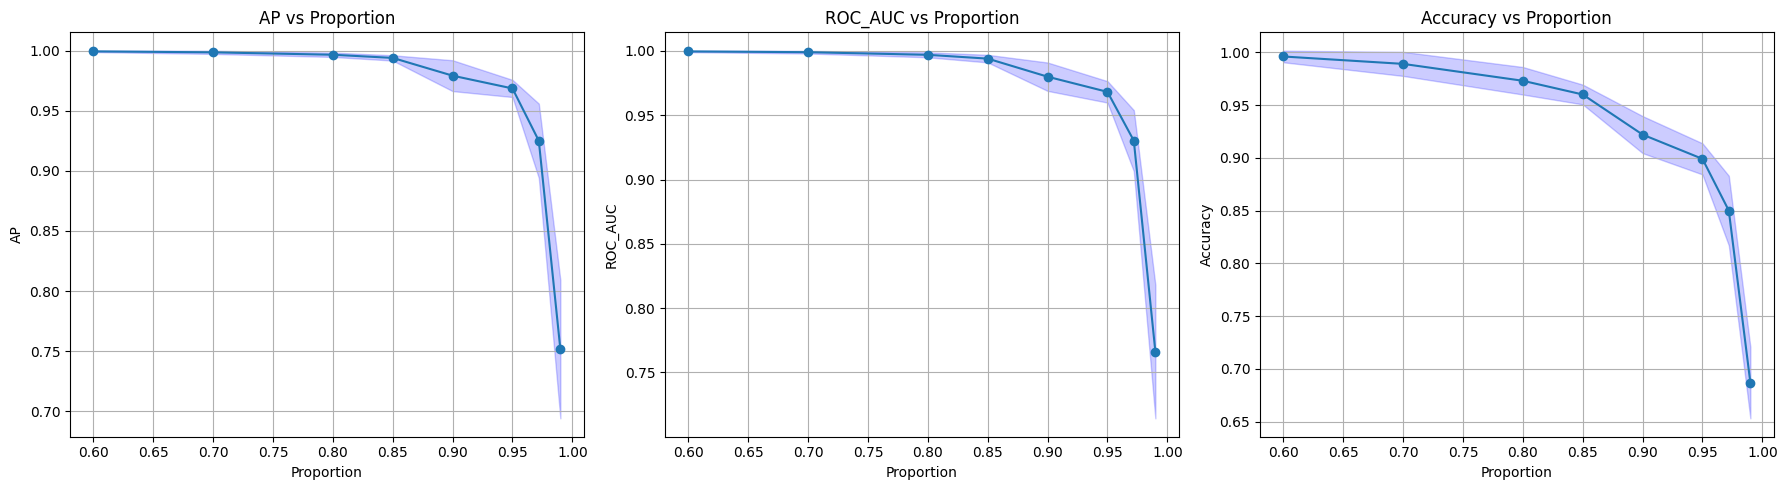

In [ ]:
import matplotlib.pyplot as plt

metrics = ['AP', 'ROC_AUC', 'Accuracy']

fig, axes = plt.subplots(1, len(metrics), figsize=(18, 5))

for i, metric in enumerate(metrics):
    mean_values = grouped_data[metric]['mean']
    std_values = grouped_data[metric]['std']
    proportions = grouped_data['proportion']

    axes[i].plot(proportions, mean_values, marker='o')
    axes[i].fill_between(proportions, mean_values - std_values, mean_values + std_values, color='blue', alpha=0.2)

    axes[i].set_title(f'{metric} vs Proportion')
    axes[i].set_xlabel('Proportion')
    axes[i].set_ylabel(metric)
    axes[i].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
equal_log_df = parse_log('experiment_equal_log.txt')
pair_log_df = parse_log('experiment_pair_log.txt')
equal_grouped_data = equal_log_df.groupby('proportion').agg(['mean', 'std']).reset_index()
pair_grouped_data = pair_log_df.groupby('proportion').agg(['mean', 'std']).reset_index()

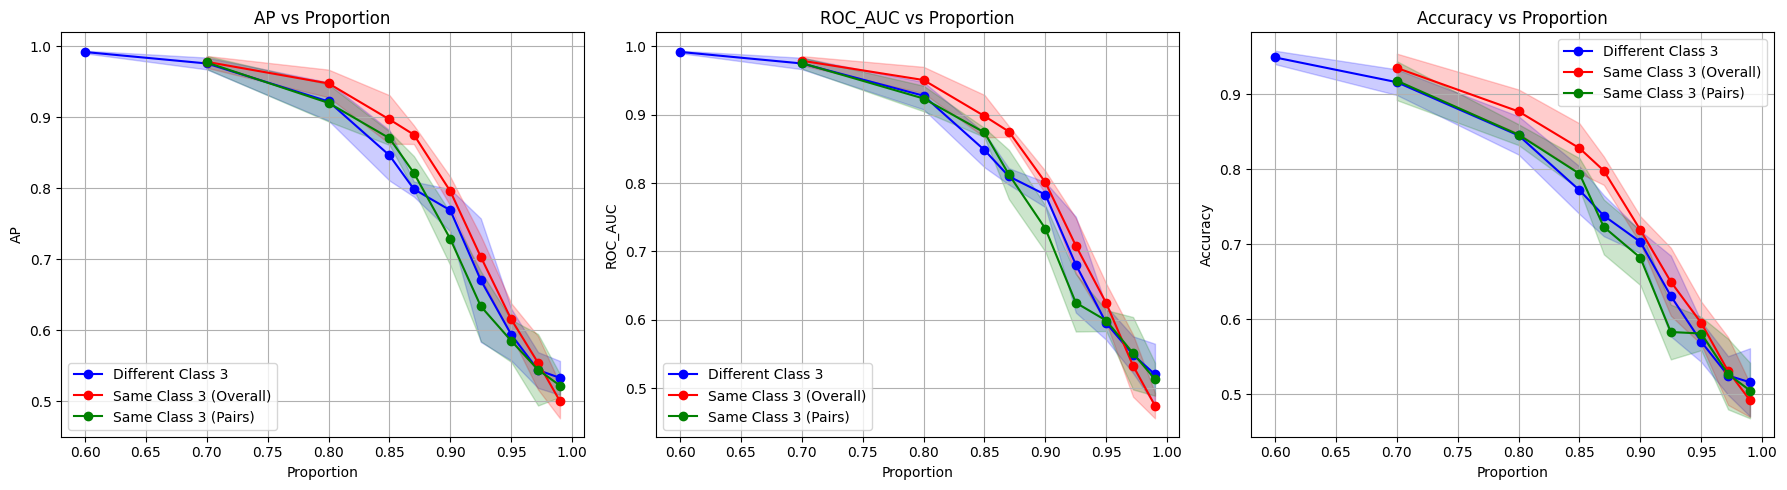

In [ ]:
metrics = ['AP', 'ROC_AUC', 'Accuracy']
experiment_data = [grouped_data, equal_grouped_data, pair_grouped_data]
experiment_labels = ["Different Class 3", "Same Class 3 (Overall)", "Same Class 3 (Pairs)"]
colors = ['blue', 'red', 'green']

fig, axes = plt.subplots(1, len(metrics), figsize=(18, 5))

for i, metric in enumerate(metrics):
    for data, label, color in zip(experiment_data, experiment_labels, colors):
        mean_values = data[metric]['mean']
        std_values = data[metric]['std']
        proportions = data['proportion']

        axes[i].plot(proportions, mean_values, marker='o', color=color, label=label)
        axes[i].fill_between(proportions, mean_values - std_values, mean_values + std_values, color=color, alpha=0.2)

    axes[i].set_title(f'{metric} vs Proportion')
    axes[i].set_xlabel('Proportion')
    axes[i].set_ylabel(metric)
    axes[i].grid(True)
    axes[i].legend()

plt.tight_layout()
plt.show()

# Эксперименты со смесью распределений

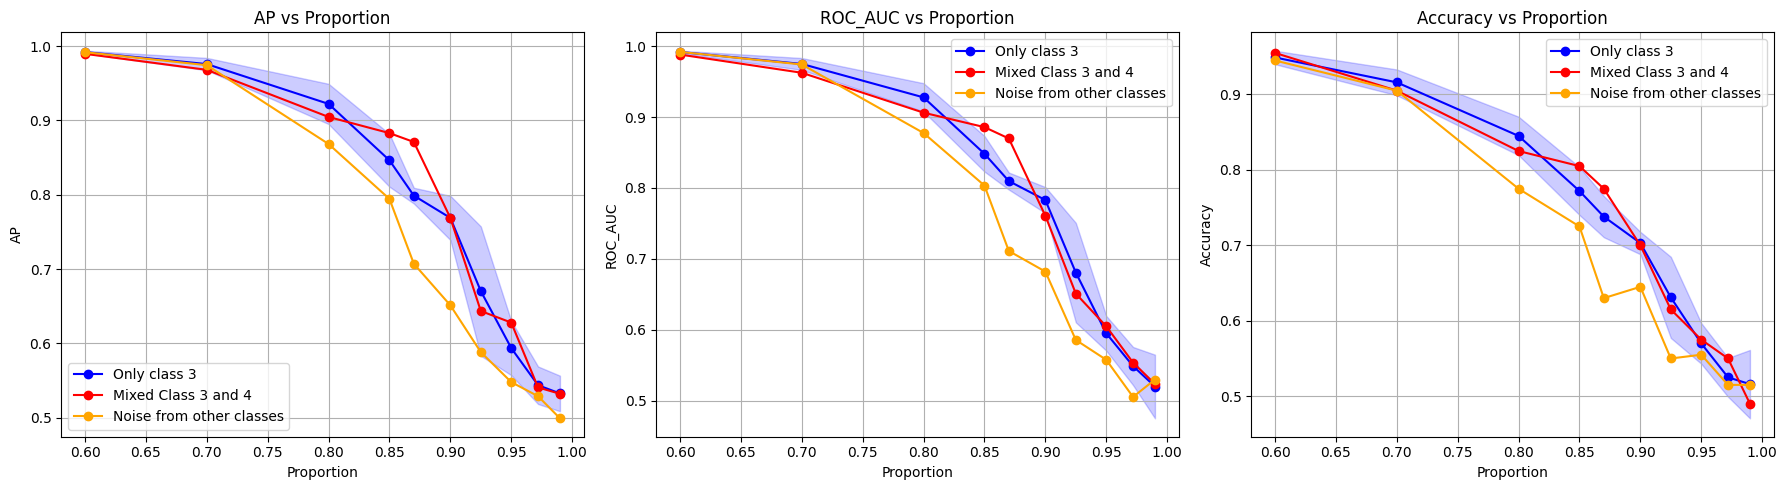

In [ ]:
import re
import pandas as pd

def parse_log_new_format(log_file):
    data = []
    with open(log_file, 'r') as f:
        proportion = None
        for line in f:
            proportion_match = re.search(r"Proportion_(\d+\.?\d*)", line)
            if proportion_match:
                proportion = float(proportion_match.group(1))
            elif proportion is not None:
                results_match = re.search(r"Results - AP: (\d+\.?\d*), ROC_AUC: (\d+\.?\d*), Accuracy: (\d+\.?\d*)", line)
                if results_match:
                    ap = float(results_match.group(1))
                    roc_auc = float(results_match.group(2))
                    accuracy = float(results_match.group(3))
                    data.append({'proportion': proportion, 'AP': ap, 'ROC_AUC': roc_auc, 'Accuracy': accuracy})
                    proportion = None # Reset proportion after processing results for that block
    return pd.DataFrame(data)

experiment_34_log_df_new = parse_log_new_format('experiment_34_classes_log.txt')
experiment_noise_log_df_new = parse_log_new_format('experiment_noise_classes_log.txt')
grouped_data = log_df.groupby('proportion').agg(['mean', 'std']).reset_index()

experiment_34_grouped_data_new = experiment_34_log_df_new.groupby('proportion').agg(['mean', 'std']).reset_index()
experiment_noise_grouped_data_new = experiment_noise_log_df_new.groupby('proportion').agg(['mean', 'std']).reset_index()

metrics = ['AP', 'ROC_AUC', 'Accuracy']
experiment_data_new = [grouped_data, experiment_34_grouped_data_new, experiment_noise_grouped_data_new]
experiment_labels_new = ["Only class 3", "Mixed Class 3 and 4", "Noise from other classes"]
colors_new = ["blue", 'red', 'orange']

fig, axes = plt.subplots(1, len(metrics), figsize=(18, 5))

for i, metric in enumerate(metrics):
    for data, label, color in zip(experiment_data_new, experiment_labels_new, colors_new):
        mean_values = data[metric]['mean']
        std_values = data[metric]['std']
        proportions = data['proportion']

        axes[i].plot(proportions, mean_values, marker='o', color=color, label=label)
        axes[i].fill_between(proportions, mean_values - std_values, mean_values + std_values, color=color, alpha=0.2)

    axes[i].set_title(f'{metric} vs Proportion')
    axes[i].set_xlabel('Proportion')
    axes[i].set_ylabel(metric)
    axes[i].grid(True)
    axes[i].legend()

plt.tight_layout()
plt.show()